In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import torch.nn.functional as F

import matplotlib.pyplot as plt

from collections import OrderedDict

import pandas as pd
import seaborn as sns

/home/secondvoca/anaconda3/envs/torch/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Download training data from open datasets.
training_data = datasets.MNIST(
  root="data",
  train=True,
  download=True,
  transform=ToTensor(),
)

batch_size = 128

# training_data.data = training_data.data[training_data.targets < 3]
# training_data.targets = training_data.targets[training_data.targets < 3]

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)

for X, y in train_dataloader:
  print(f"Shape of X [N, C, H, W]: {X.shape} {X.dtype}")
  print(f"Shape of y: {y.shape} {y.dtype}")
  break

Shape of X [N, C, H, W]: torch.Size([128, 1, 28, 28]) torch.float32
Shape of y: torch.Size([128]) torch.int64


In [64]:
# matrix1 = np.zeros((5, 10))
# row = np.array([0,1,2,3,4])
# column = np.array([9,9,2,3,9,2,1,3,3,1])

# index = np.stack(np.meshgrid(row,column), -1).reshape(-1,2) 
# matrix1[index[:,0], index[:,1]] = 1

tmp=torch.rand(3,3)
row = torch.arange(3)
col = torch.tensor([1,2,0])
tmp[row, col] = 1
tmp

tensor([[0.6599, 1.0000, 0.2757],
        [0.5532, 0.5533, 1.0000],
        [1.0000, 0.9065, 0.0751]])

In [66]:
for x, y in train_dataloader:
  x = x.reshape([-1, 28*28])
  x[torch.arange(len(x)), y] = 1
  print(x[0])
  break


tensor([0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 

In [130]:
ps = torch.tensor([[0, 0], [1, 0], [0.5, 3**0.5/2]])
xs = torch.arange(2, 6).reshape(-1, 2).to(torch.float)
idx = torch.tensor([[1,0,0],[0,1,0]])
xs

tensor([[2., 3.],
        [4., 5.]])

In [129]:
(ps[0] - xs[0]).square().sum()

tensor(13.)

In [131]:
torch.stack([xs]*3, dim=1)

tensor([[[2., 3.],
         [2., 3.],
         [2., 3.]],

        [[4., 5.],
         [4., 5.],
         [4., 5.]]])

In [132]:
(torch.stack([xs]*3, dim=1) - ps)

tensor([[[2.0000, 3.0000],
         [1.0000, 3.0000],
         [1.5000, 2.1340]],

        [[4.0000, 5.0000],
         [3.0000, 5.0000],
         [3.5000, 4.1340]]])

In [139]:
((torch.stack([xs]*3, dim=1) - ps).square().sum(dim=2) * idx).max(dim=1).values

tensor([13., 34.])

In [12]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [177]:
encoder = nn.Sequential(
  # nn.Flatten(),
  nn.Linear(784, 512),
  nn.Tanh(),
  nn.Linear(512, 128),
  nn.Tanh(),
  nn.Linear(128, 64),
  nn.Tanh(),
  nn.Linear(64, 5),
)

decoder = nn.Sequential(
  nn.Linear(2, 64),
  nn.Tanh(),
  nn.Linear(64, 128),
  nn.Tanh(),
  nn.Linear(128, 512),
  nn.Tanh(),
  nn.Linear(512, 784),
  nn.Sigmoid(),
  # nn.Unflatten(1, [1, 28, 28])
)

model = nn.Sequential(OrderedDict([
          ('encoder', encoder),
          ('decoder', decoder),
        ])).to(device)

optimizer = torch.optim.Adam(model.parameters())

In [172]:
def train(model, dataloader, optimizer):

  hist = torch.zeros(len(dataloader))

  model.train()
  for batch, (x, y) in enumerate(dataloader):
    x_in = x.reshape([-1, 28*28])
    x_in[torch.arange(len(x)), y] = 1
    x, x_in = x.view([-1, 28*28]).to(device), x_in.to(device)
    # x, y = x.to(device), y.to(device)

    # Compute prediction error
    h = model.get_submodule('encoder')(x_in)
    z = h[:, :2]
    # alpha = F.softplus(h[:, 2]) + 1e-6

    ps = torch.tensor([[0, 0], [1, 0], [0.5, 3**0.5/2]]).to(device)
    # ((torch.stack([xs]*3, dim=1) - ps).square().sum(dim=2) * idx).max(dim=1).values

    idx = x_in[:, :3]
    dist = (((torch.stack([z]*3, dim=1) - ps).square().sum(dim=2) * idx).max(dim=1).values).mean()
    pred = model.get_submodule('decoder')(z)
    likelihood = (x*pred.log() + (1 - x)*(1 - pred).log()).sum(dim=[1]).mean()
    loss = -likelihood + dist

    # Backpropagation
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    hist[batch] = loss.item()

  return hist

In [173]:
model.to(device)
hist = torch.zeros(0)
for _ in range(50):
  tmp = train(model, train_dataloader, optimizer)
  hist = torch.cat([hist, tmp])
  

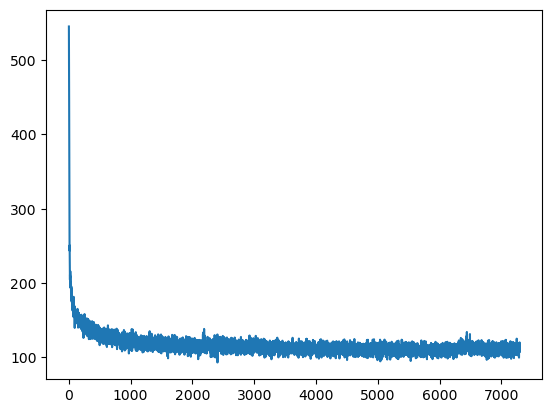

In [174]:
plt.plot(hist)
plt.show()

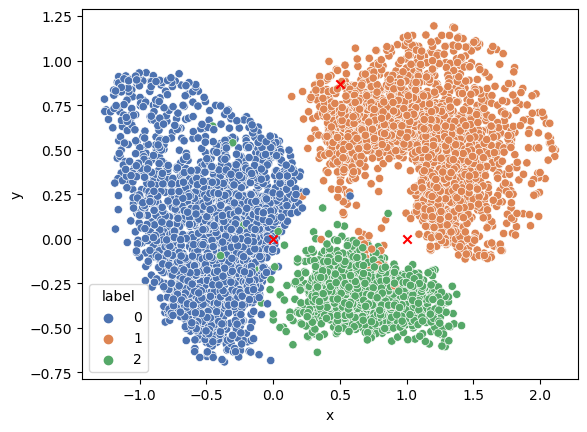

In [169]:
df = pd.DataFrame(columns=['x', 'y', 'label'])

model.to('cpu')

idx = 0
for x, y in train_dataloader:
  x_in = x.reshape([-1, 28*28])
  x_in[torch.arange(len(x)), y] = 1
  h = model.get_submodule('encoder')(x_in)
  mu = h[:, :2].detach().numpy()
  
  tmp = pd.DataFrame(
    {
      'x': mu[:, 0],
      'y': mu[:, 1],
      'label': y
    }
  )
  df = pd.concat([df, tmp], ignore_index=True)

  idx += 1
  if idx > 50:
    break

sns.scatterplot(data=df, x="x", y="y", hue="label", palette="deep")
plt.scatter([0, 1, 0.5], [0, 0, 3**0.5/2], marker='x', color='red')

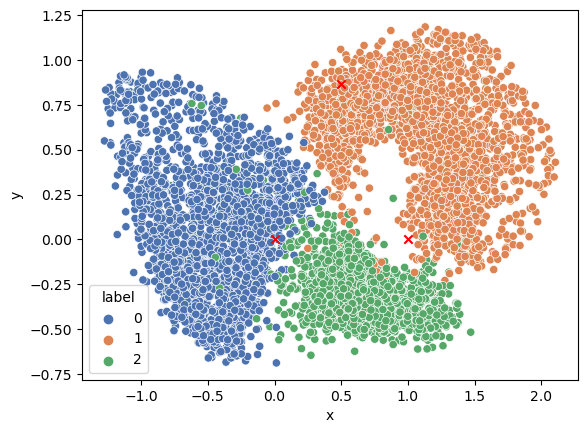

In [170]:
df = pd.DataFrame(columns=['x', 'y', 'label'])

model.to('cpu')

idx = 0
for x, y in train_dataloader:
  x_in = x.reshape([-1, 28*28])
  # x_in[torch.arange(len(x)), y] = 1
  h = model.get_submodule('encoder')(x_in)
  mu = h[:, :2].detach().numpy()
  
  tmp = pd.DataFrame(
    {
      'x': mu[:, 0],
      'y': mu[:, 1],
      'label': y
    }
  )
  df = pd.concat([df, tmp], ignore_index=True)

  idx += 1
  if idx > 50:
    break

sns.scatterplot(data=df, x="x", y="y", hue="label", palette="deep")
plt.scatter([0, 1, 0.5], [0, 0, 3**0.5/2], marker='x', color='red')

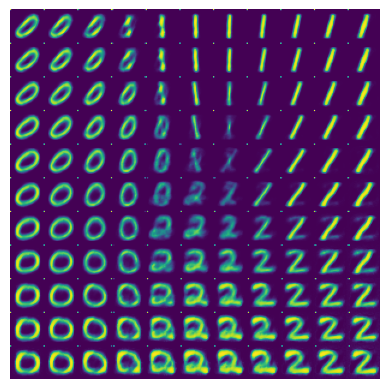

In [164]:
grid_x, grid_y = torch.meshgrid(torch.linspace(-1, 2, 11), torch.linspace(-1, 1, 11), indexing='xy')
points = torch.stack([grid_x, grid_y], dim=2)

def plot_reconstructed(decoder, points):
  w = 28
  n = len(points)
  img = torch.zeros((n*w, n*w))
  for i, r in enumerate(points):
    tmps = decoder(r).view([-1, 1, 28, 28])
    for j, tmp in enumerate(tmps):
      img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = tmp[0]
  plt.axis('off')
  plt.imshow(img)

with torch.no_grad():
  plot_reconstructed(model.get_submodule('decoder'), points)
  

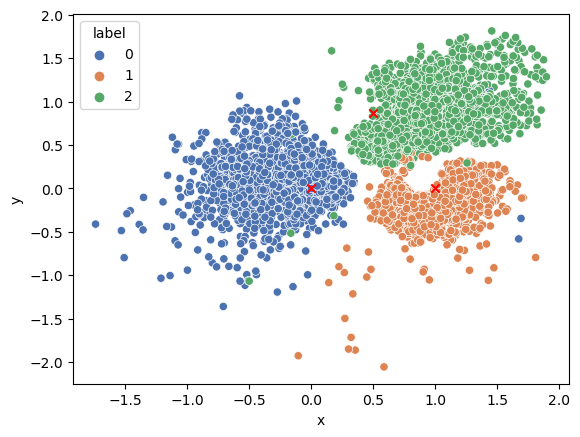

In [175]:
df = pd.DataFrame(columns=['x', 'y', 'label'])

model.to('cpu')

idx = 0
for x, y in train_dataloader:
  x_in = x.reshape([-1, 28*28])
  x_in[torch.arange(len(x)), y] = 1
  h = model.get_submodule('encoder')(x_in)
  mu = h[:, :2].detach().numpy()
  
  tmp = pd.DataFrame(
    {
      'x': mu[:, 0],
      'y': mu[:, 1],
      'label': y
    }
  )
  df = pd.concat([df, tmp], ignore_index=True)

  idx += 1
  if idx > 50:
    break

sns.scatterplot(data=df, x="x", y="y", hue="label", palette="deep")
plt.scatter([0, 1, 0.5], [0, 0, 3**0.5/2], marker='x', color='red')

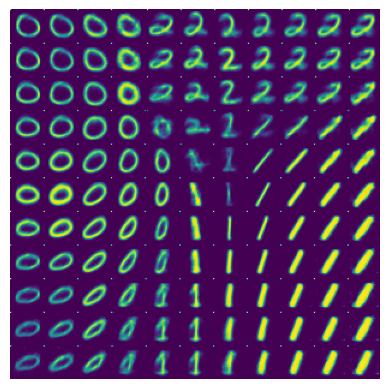

In [176]:
grid_x, grid_y = torch.meshgrid(torch.linspace(-1, 2, 11), torch.linspace(-1, 1, 11), indexing='xy')
points = torch.stack([grid_x, grid_y], dim=2)

def plot_reconstructed(decoder, points):
  w = 28
  n = len(points)
  img = torch.zeros((n*w, n*w))
  for i, r in enumerate(points):
    tmps = decoder(r).view([-1, 1, 28, 28])
    for j, tmp in enumerate(tmps):
      img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = tmp[0]
  plt.axis('off')
  plt.imshow(img)

with torch.no_grad():
  plot_reconstructed(model.get_submodule('decoder'), points)
  

In [185]:
def train_un(model, dataloader, optimizer):

  hist = torch.zeros(len(dataloader))

  model.train()
  for batch, (x, y) in enumerate(dataloader):
    x = x.view([-1, 28*28]).to(device)
    # x, y = x.to(device), y.to(device)

    # Compute prediction error
    h = model.get_submodule('encoder')(x)
    z = h[:, :2]
    pred_labels = h[:, 2:]
    labels = pred_labels.argmax(dim=1)
    idx = F.one_hot(labels, num_classes=3)

    ps = torch.tensor([[0, 0], [1, 0], [0.5, 3**0.5/2]]).to(device)
    # ((torch.stack([xs]*3, dim=1) - ps).square().sum(dim=2) * idx).max(dim=1).values

    dist = (((torch.stack([z]*3, dim=1) - ps).square().sum(dim=2) * idx).max(dim=1).values).mean()
    pred = model.get_submodule('decoder')(z)
    likelihood = (x*pred.log() + (1 - x)*(1 - pred).log()).sum(dim=[1]).mean()
    loss = -likelihood + dist

    # Backpropagation
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    hist[batch] = loss.item()

  return hist

In [186]:
model.to(device)
hist = torch.zeros(0)
for _ in range(5):
  tmp = train(model, train_dataloader, optimizer)
  hist = torch.cat([hist, tmp])
  

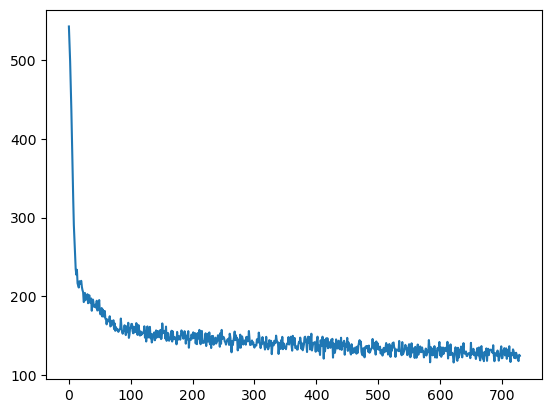

In [187]:
plt.plot(hist)
plt.show()

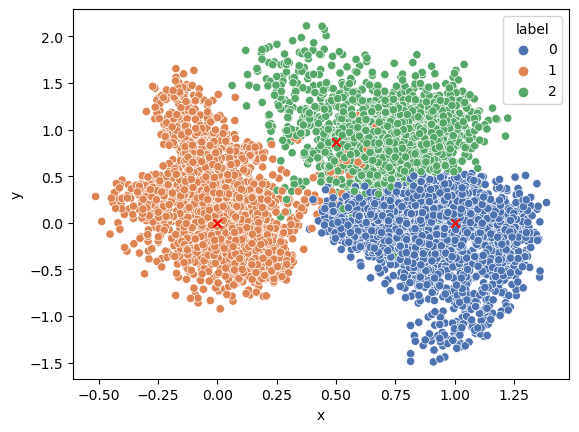

In [188]:
df = pd.DataFrame(columns=['x', 'y', 'label'])

model.to('cpu')

idx = 0
for x, y in train_dataloader:
  x_in = x.reshape([-1, 28*28])
  # x_in[torch.arange(len(x)), y] = 1
  h = model.get_submodule('encoder')(x_in)
  mu = h[:, :2].detach().numpy()
  
  tmp = pd.DataFrame(
    {
      'x': mu[:, 0],
      'y': mu[:, 1],
      'label': y
    }
  )
  df = pd.concat([df, tmp], ignore_index=True)

  idx += 1
  if idx > 50:
    break

sns.scatterplot(data=df, x="x", y="y", hue="label", palette="deep")
plt.scatter([0, 1, 0.5], [0, 0, 3**0.5/2], marker='x', color='red')

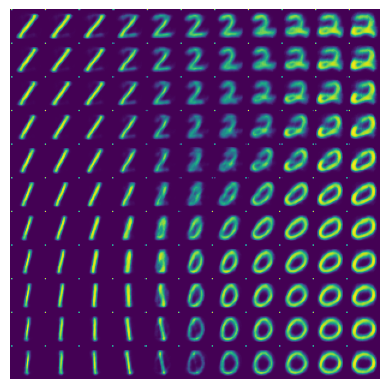

In [190]:
grid_x, grid_y = torch.meshgrid(torch.linspace(-0.3, 1.3, 11), torch.linspace(-0.5, 1.3, 11), indexing='xy')
points = torch.stack([grid_x, grid_y], dim=2)

def plot_reconstructed(decoder, points):
  w = 28
  n = len(points)
  img = torch.zeros((n*w, n*w))
  for i, r in enumerate(points):
    tmps = decoder(r).view([-1, 1, 28, 28])
    for j, tmp in enumerate(tmps):
      img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = tmp[0]
  plt.axis('off')
  plt.imshow(img)

with torch.no_grad():
  plot_reconstructed(model.get_submodule('decoder'), points)
  